In [2]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot

**Main imports**

In [5]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [10]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=16, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=16, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

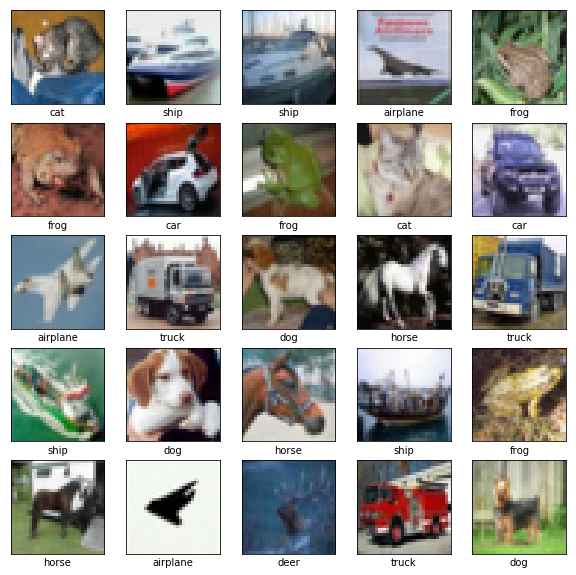

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [56]:
# define the model (a simple autoencoder)
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_features=3*32*32, out_features=512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=512, out_features=32))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=32, out_features=512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=512, out_features=3*32*32))
        layers.append(nn.Sigmoid())
        self.layers = layers

    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

    # encode (flatten as linear, then run first half of network)
    def encode(self, x):
        x = x.view(x.size(0), -1)
        for i in range(4):
            x = self.layers[i](x)
        return x

    # decode (run second half of network then unflatten)
    def decode(self, x):
        for i in range(4,8):
            x = self.layers[i](x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

N = MyNetwork().to(device)
try:
    MODEL_PATH='/Users/FatemaK/Desktop/year3/SSA/ml/ssa-ml/pegasus_model.pkl'
    N.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
    N.eval()
except:
    print('no model found')

print(f'> Number of network parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0
liveplot = PlotLosses()

> Number of network parameters 3182624


**Main training loop**

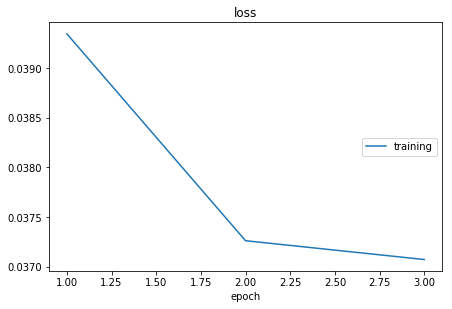

loss:
training   (min:    0.037, max:    0.039, cur:    0.037)


KeyboardInterrupt: 

In [13]:
# training loop, feel free to also train on the test dataset if you like for generating the pegasus
while (epoch<10):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        loss = ((p-x)**2).mean() # simple l2 loss
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)

    # NOTE: live plot library has dumb naming forcing our 'test' to be called 'validation'
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus by interpolating between the latent space encodings of a horse and a bird**

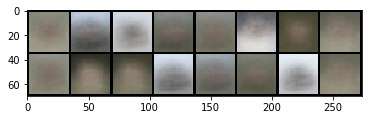

In [57]:
# show some inputs
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

# show some predictions
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(p).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

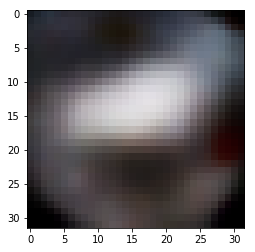

In [58]:
example_1 = (test_loader.dataset[13][0]).to(device)  # horse
example_2 = (test_loader.dataset[160][0]).to(device) # bird

example_1_code = N.encode(example_1.unsqueeze(0))
example_2_code = N.encode(example_2.unsqueeze(0))

# this is some sad blurry excuse of a Pegasus, hopefully you can make a better one
bad_pegasus = N.decode(0.9*example_1_code + 0.1*example_2_code).squeeze(0)

plt.grid(False)
plt.imshow(bad_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))

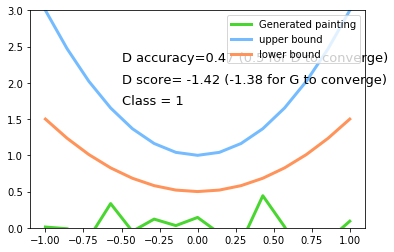

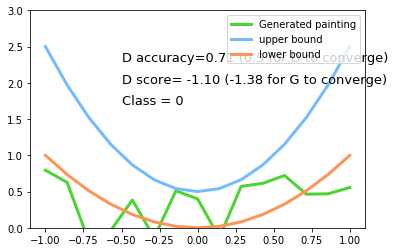

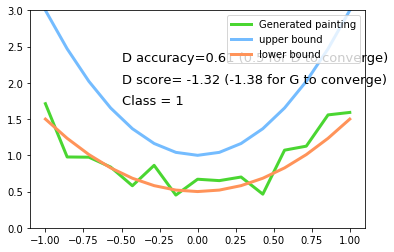

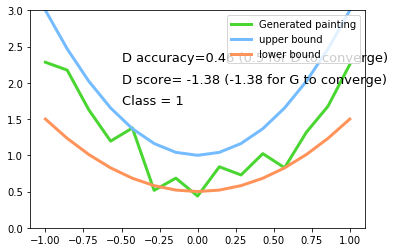

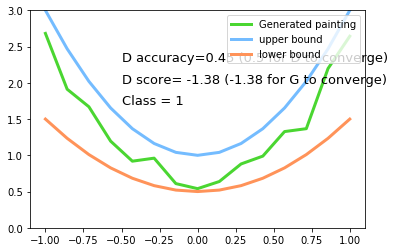

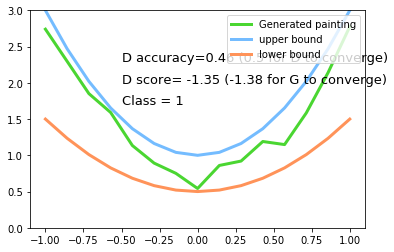

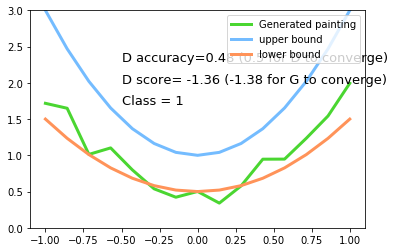

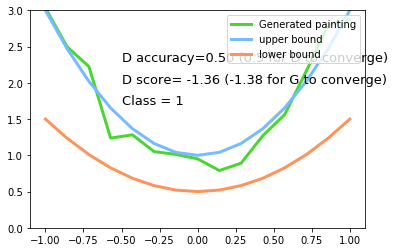

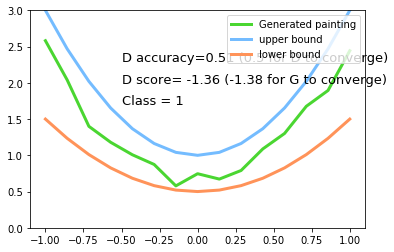

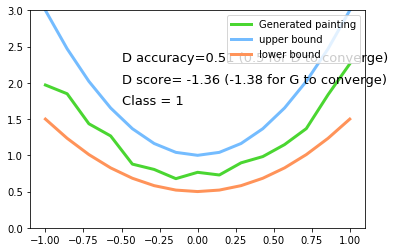

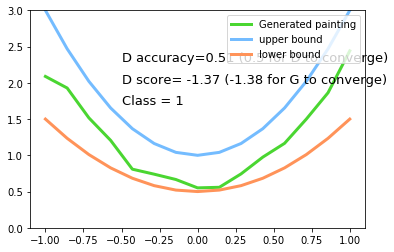

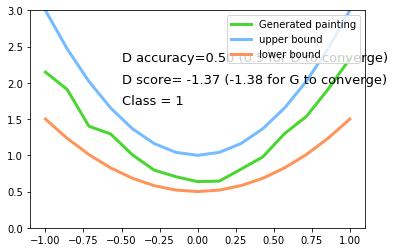

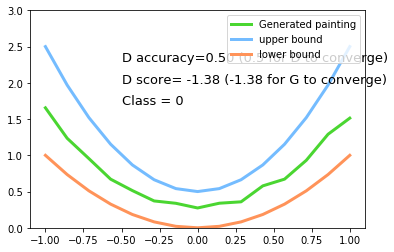

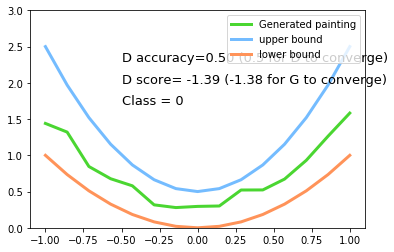

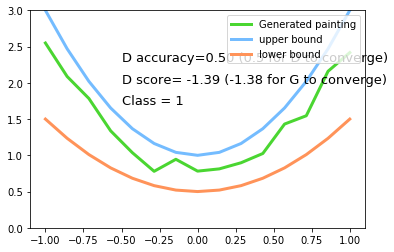

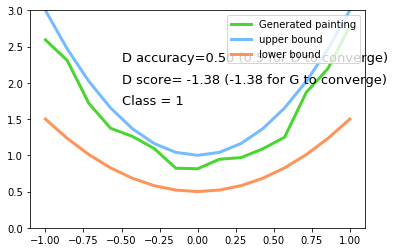

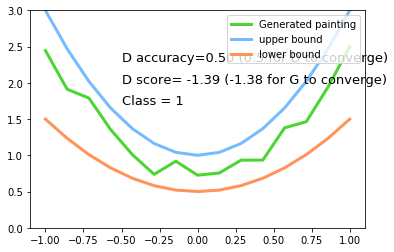

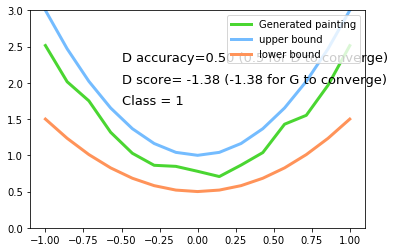

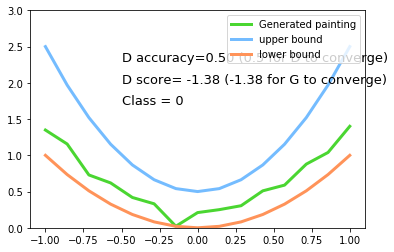

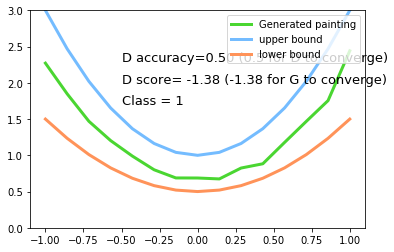

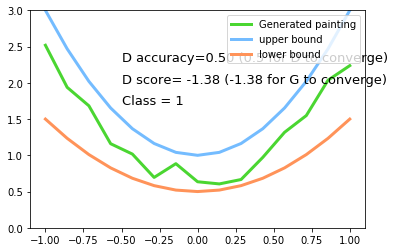

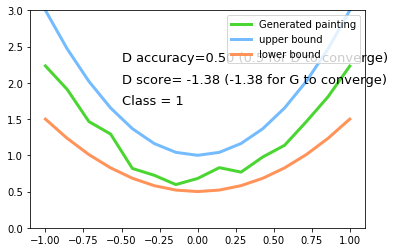

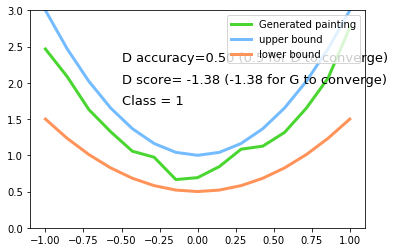

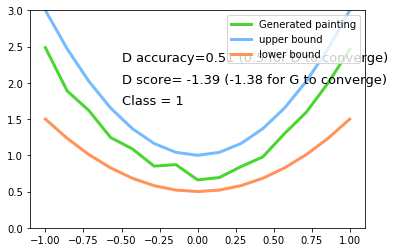

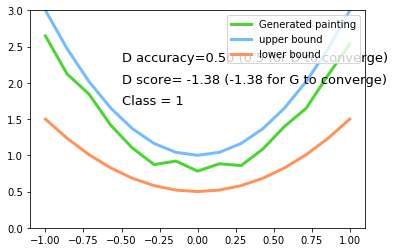

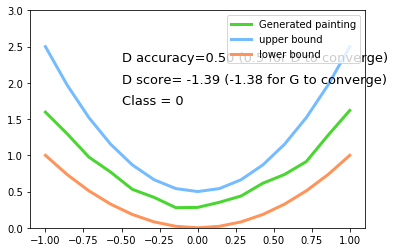

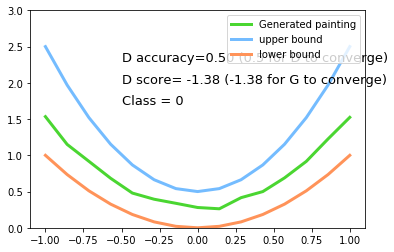

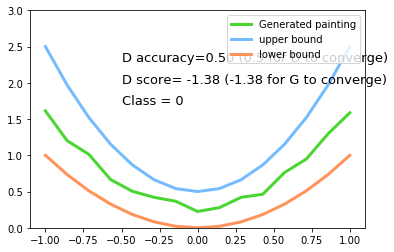

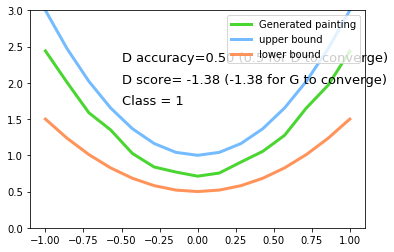

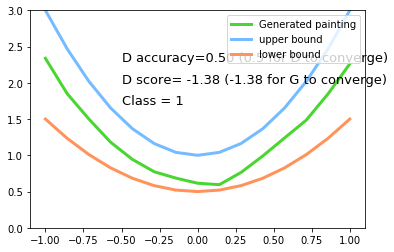

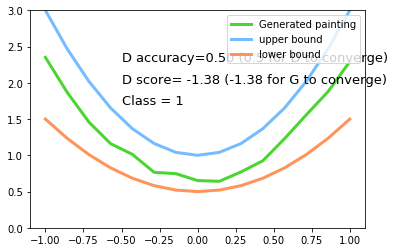

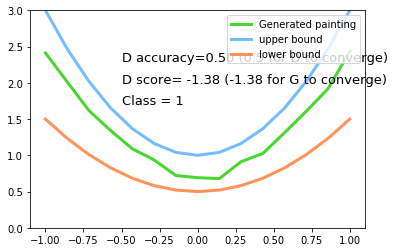

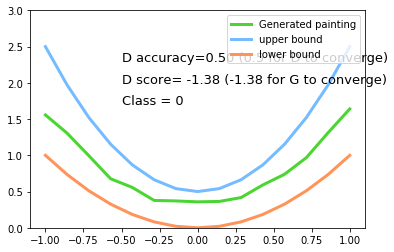

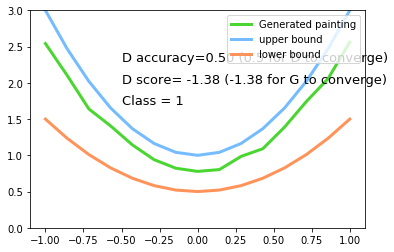

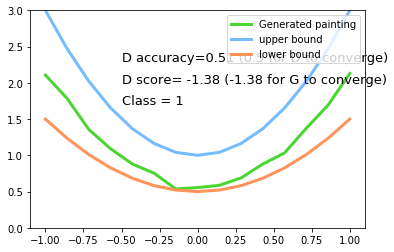

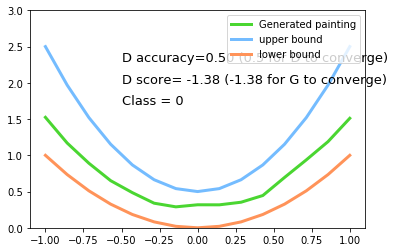

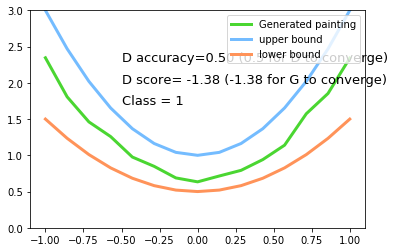

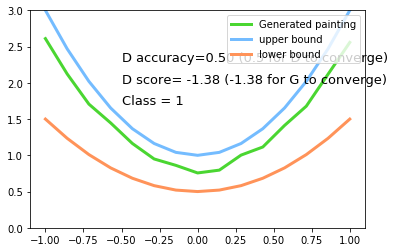

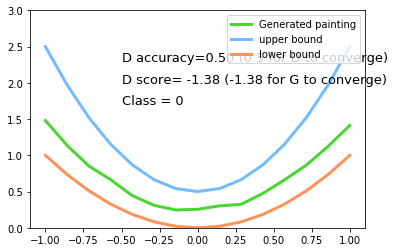

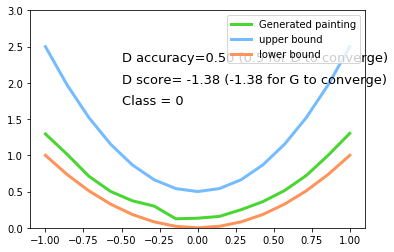

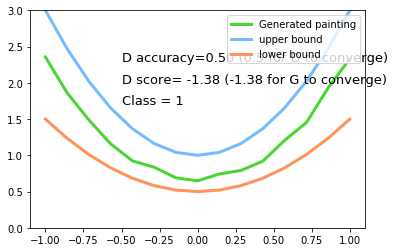

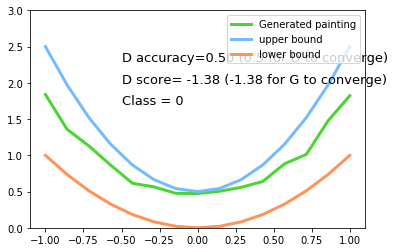

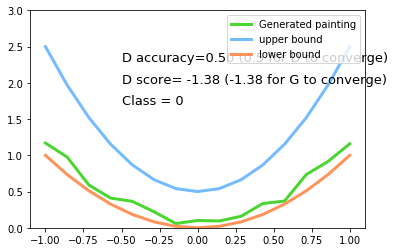

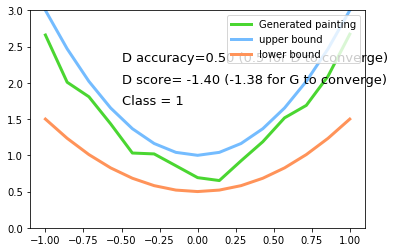

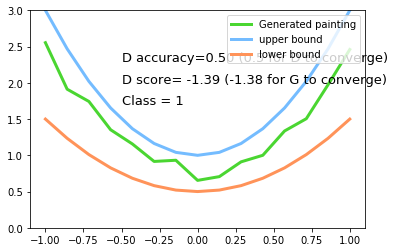

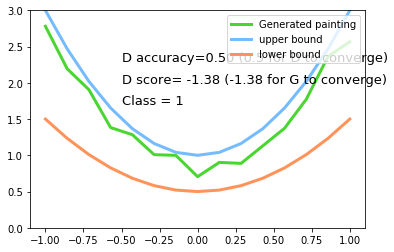

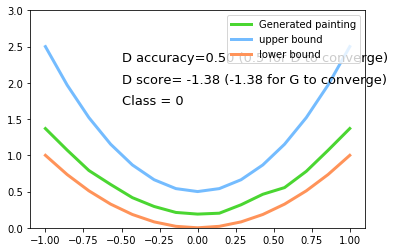

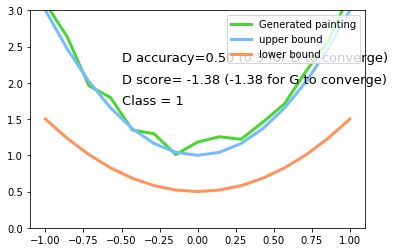

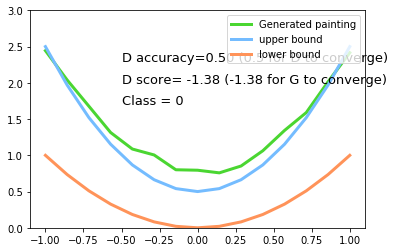

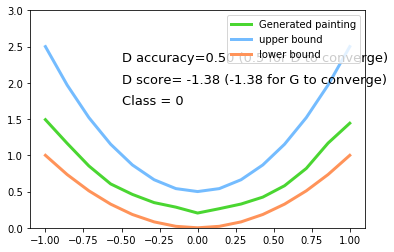

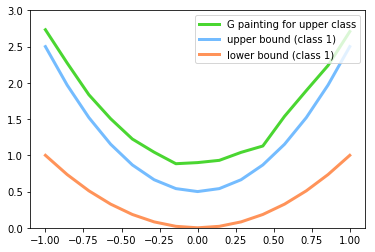

In [6]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
numpy
matplotlib
"""
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
# plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
# plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
# plt.legend(loc='upper right')
# plt.show()


def artist_works_with_labels():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    labels = (a-1) > 0.5            # upper paintings (1), lower paintings (0), two classes
    paintings = torch.from_numpy(paintings).float()
    labels = torch.from_numpy(labels.astype(np.float32))
    return paintings, labels


G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS+1, 128),          # random ideas (could from normal distribution) + class label
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS+1, 128),   # receive art work either from the famous artist or a newbie like G with label
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

plt.ion()   # something about continuous plotting

for step in range(10000):
    artist_paintings, labels = artist_works_with_labels()           # real painting, label from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)                      # random ideas
    G_inputs = torch.cat((G_ideas, labels), 1)                      # ideas with labels
    G_paintings = G(G_inputs)                                       # fake painting w.r.t label from G

    D_inputs0 = torch.cat((artist_paintings, labels), 1)            # all have their labels
    D_inputs1 = torch.cat((G_paintings, labels), 1)
    prob_artist0 = D(D_inputs0)                 # D try to increase this prob
    prob_artist1 = D(D_inputs1)                 # D try to reduce this prob

    D_score0 = torch.log(prob_artist0)          # maximise this for D
    D_score1 = torch.log(1. - prob_artist1)     # maximise this for D
    D_loss = - torch.mean(D_score0 + D_score1)  # minimise the negative of both two above for D
    G_loss = torch.mean(D_score1)               # minimise D score w.r.t G

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 200 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        bound = [0, 0.5] if labels.data[0, 0] == 0 else [0.5, 1]
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.text(-.5, 1.7, 'Class = %i' % int(labels.data[0, 0]), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.1)

plt.ioff()
plt.show()

# plot a generated painting for upper class
z = torch.randn(1, N_IDEAS)
label = torch.FloatTensor([[1.]])     # for upper class
G_inputs = torch.cat((z, label), 1)
G_paintings = G(G_inputs)
plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='G painting for upper class',)
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound (class 1)')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound (class 1)')
plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.show()

torch.Size([60000, 28, 28])
torch.Size([60000])


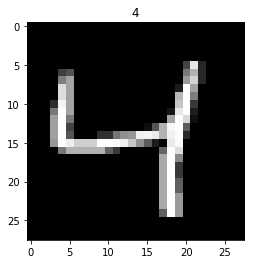

Epoch:  0 | train loss: 0.2323


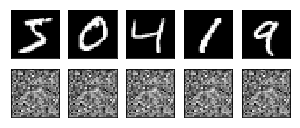

Epoch:  0 | train loss: 0.0594


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0603


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0572


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0522


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0513


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0464


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0478


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0456


<Figure size 432x288 with 0 Axes>

Epoch:  0 | train loss: 0.0424


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0453


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0441


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0422


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0416


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0382


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0424


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0363


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0396


<Figure size 432x288 with 0 Axes>

Epoch:  1 | train loss: 0.0392


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0403


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0408


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0371


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0405


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0379


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0374


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0377


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0393


<Figure size 432x288 with 0 Axes>

Epoch:  2 | train loss: 0.0363


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0352


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0401


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0363


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0364


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0372


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0362


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0349


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0374


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0373


<Figure size 432x288 with 0 Axes>

Epoch:  3 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0361


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0390


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0355


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0350


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0366


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0333


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0350


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0337


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0379


<Figure size 432x288 with 0 Axes>

Epoch:  4 | train loss: 0.0354


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0318


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0376


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0363


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0358


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0375


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0370


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0353


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0345


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0364


<Figure size 432x288 with 0 Axes>

Epoch:  5 | train loss: 0.0371


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0353


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0355


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0348


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0344


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0349


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0358


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0343


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0325


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0326


<Figure size 432x288 with 0 Axes>

Epoch:  6 | train loss: 0.0360


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0359


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0359


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0370


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0336


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0369


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0339


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0362


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0329


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0364


<Figure size 432x288 with 0 Axes>

Epoch:  7 | train loss: 0.0336


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0324


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0349


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0357


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0355


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0368


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0356


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0363


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0326


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0308


<Figure size 432x288 with 0 Axes>

Epoch:  8 | train loss: 0.0330


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0351


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0394


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0313


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0357


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0325


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0320


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0330


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0284


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0322


<Figure size 432x288 with 0 Axes>

Epoch:  9 | train loss: 0.0332


<Figure size 432x288 with 0 Axes>

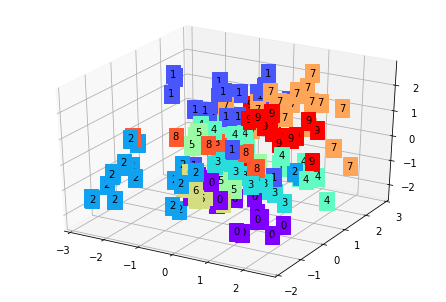

In [9]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np


# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = True
N_TEST_IMG = 5

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# initialize figure
f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for i in range(N_TEST_IMG):
    a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()

# visualize in 3D plot
view_data = train_data.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.
encoded_data, _ = autoencoder(view_data)
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()

In [41]:
np.random.rand(3, 512, 256).T.shape

(256, 512, 3)